### Author: William C Francis (willcf)
##Solution 2
### (i)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


####Downloading the dataset

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor())
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

### Creating x_train and y_train with 1000 images from each class and binarizing the pixels

In [3]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)
        
y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

### Resizing the images from 28x28 to 14x14

In [4]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,14,14])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (14,14)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

### Binarizing 

In [5]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

### Creating dataloaders

In [6]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

###(ii)
### Variational Auto Encoder model

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(196, 128) #Encoder
        self.fc21 = nn.Linear(128, 8) #mu
        self.fc22 = nn.Linear(128, 8) #sigma

        self.fc3 = nn.Linear(8, 128) #Decoder
        self.fc4 = nn.Linear(128, 196)
        
    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std
    
    def sampling(self, mu, std): # Reparameterization trick
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        return 0.5*((eps1 * std + mu) + (eps2 * std + mu)) # Using two samples to compute expectation over z

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h)) 
    
    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 196))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std
model = VAE()
if torch.cuda.is_available():
    model.cuda()

In [8]:
# Save the trained 14x14 VAE weights to disk so we can load them elsewhere
save_path = "models/vae_14x14_best.pth"
torch.save(model.state_dict(), save_path)
print(f"Saved 14x14 VAE state_dict to {save_path}")

Saved 14x14 VAE state_dict to models/vae_14x14_best.pth


### Defining loss, optimizer and LR scheduler

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5, 
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std): 
    ERR = F.binary_cross_entropy(y, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

c:\Users\keert\anaconda3\envs\tf_gpu_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Training and Validating

In [23]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(1, 20):
    
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.to(device)
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.to(device)
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          # ensure scalar (no grad) for plotting
          testl.append(terr.detach().item()/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(trainloader.dataset)))
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(device)
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld
    
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

====> Epoch: 1 Average loss: -32.3098
====> Test set loss: -32.6400
====> Epoch: 2 Average loss: -32.2864
====> Test set loss: -32.9617
====> Epoch: 2 Average loss: -32.2864
====> Test set loss: -32.9617
====> Epoch: 3 Average loss: -32.2224
====> Test set loss: -32.4931
====> Epoch: 3 Average loss: -32.2224
====> Test set loss: -32.4931
====> Epoch: 4 Average loss: -32.0881
====> Test set loss: -32.9639
====> Epoch: 4 Average loss: -32.0881
====> Test set loss: -32.9639
====> Epoch: 5 Average loss: -32.0301
====> Test set loss: -32.4523
====> Epoch: 5 Average loss: -32.0301
====> Test set loss: -32.4523
====> Epoch: 6 Average loss: -31.9722
====> Test set loss: -32.6514
====> Epoch: 6 Average loss: -31.9722
====> Test set loss: -32.6514
====> Epoch: 7 Average loss: -31.9209
====> Test set loss: -32.6218
====> Epoch: 7 Average loss: -31.9209
====> Test set loss: -32.6218
====> Epoch: 8 Average loss: -31.8346
====> Test set loss: -32.6076
====> Epoch: 8 Average loss: -31.8346
====> Test

In [25]:
# Save the trained 14x14 VAE weights AFTER training
save_path = "models/vae_14x14_best.pth"
try:
    torch.save(model.state_dict(), save_path)
    print(f"Saved trained 14x14 VAE state_dict to {save_path}")
except NameError as e:
    print("Model is not defined in this kernel. Run the training cell first, then re-run this cell.")

Saved trained 14x14 VAE state_dict to models/vae_14x14_best.pth


### (iii) Plotting the first and second term of ELBO as a function of weight updates

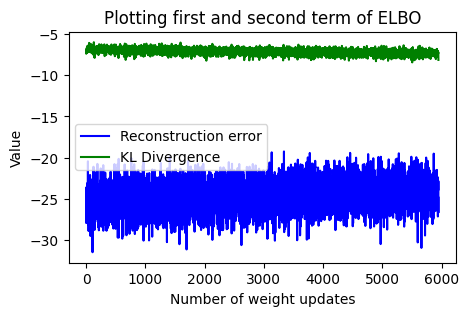

In [26]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
    

### (iv) 
### Visualizing input and output from the VAE from training set

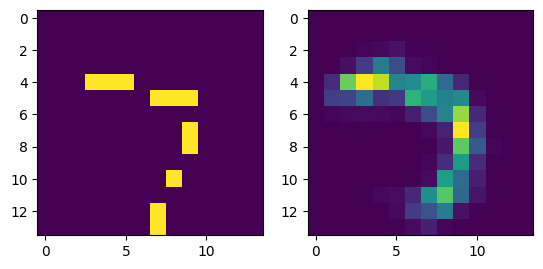

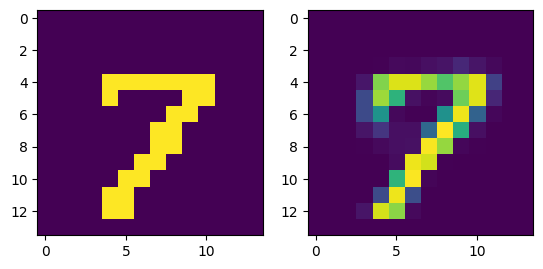

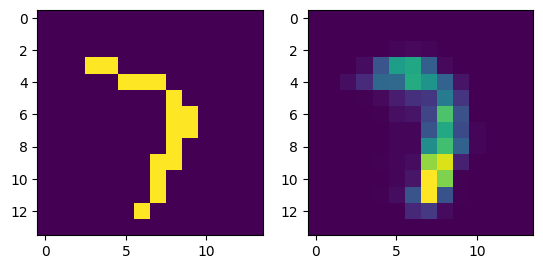

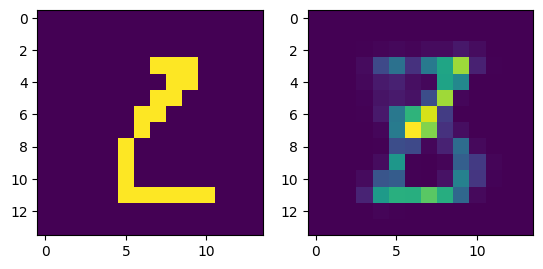

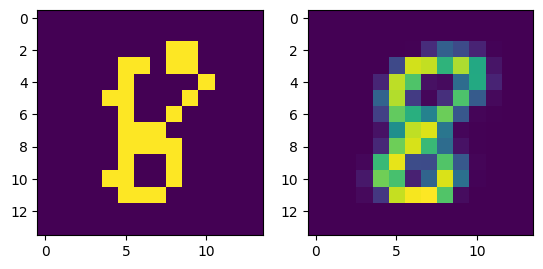

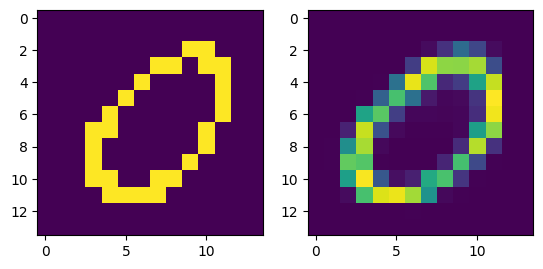

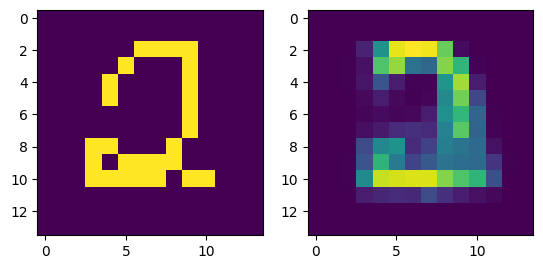

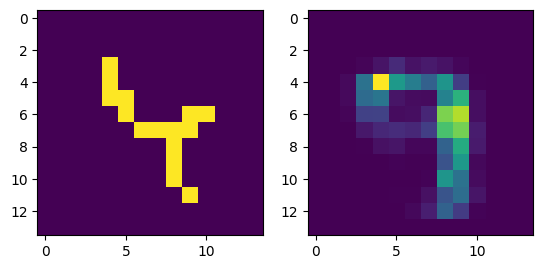

In [27]:
model.eval()
for i in range(8):
  a,t = next(iter(trainloader))
  a = a.to(device)
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### Visualizing input and output of the VAE from validation set

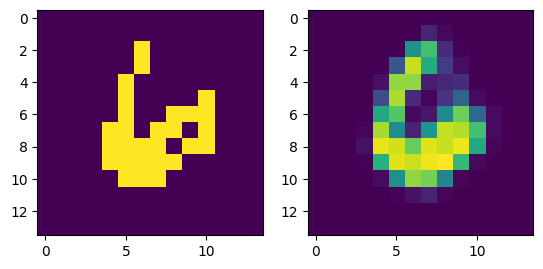

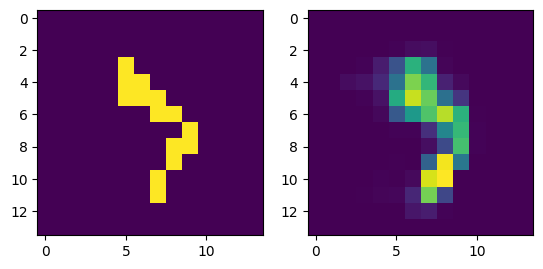

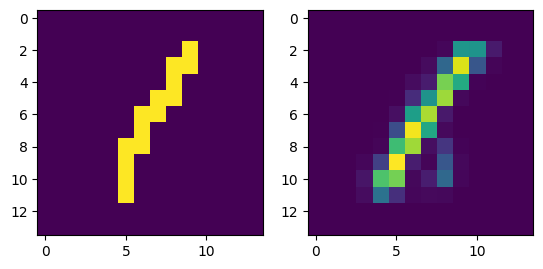

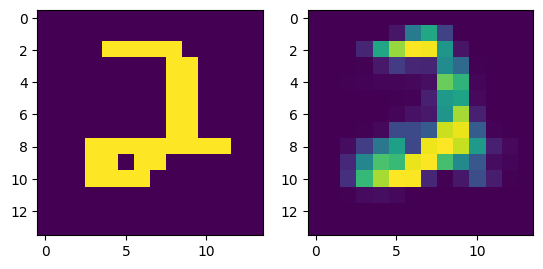

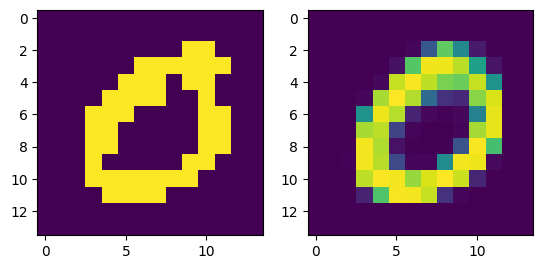

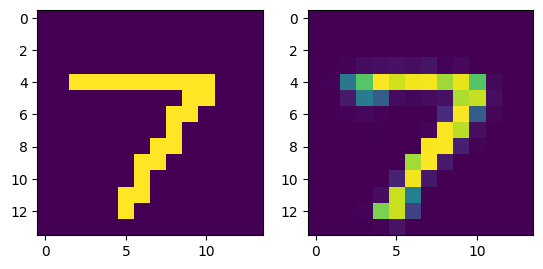

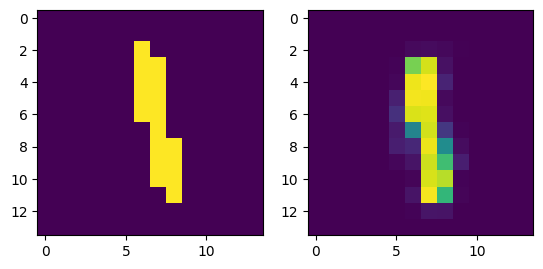

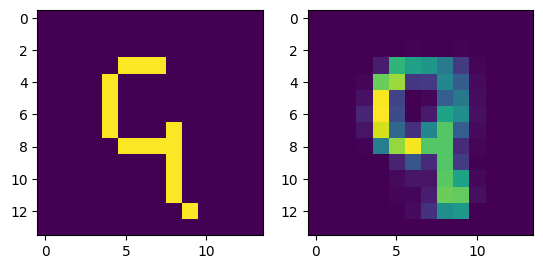

In [28]:
model.eval()
for i in range(8):
  a,t = next(iter(testloader))
  a = a.to(device)
  recon, mu, std = model(a[0])
  b = recon[0].reshape((14,14))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(a[0].detach().cpu().numpy())
  axarr[1].imshow(b.detach().cpu().numpy())

### (v)
### Synthesizing MNIST images from a Standard Gaussian Distribution

tensor([-0.7065, -0.0326, -0.7778, -0.4594,  0.2811, -0.8004,  1.2159,  1.4576])
tensor([-1.5560,  0.1326,  0.2280,  1.0364,  0.7082, -2.1766,  0.7925, -0.5355])
tensor([ 0.7886,  1.9041, -1.2527, -0.1052, -1.6983, -2.1299, -1.5280, -1.4847])
tensor([-1.5092, -0.8634,  1.1391,  0.0876,  2.0631, -0.6838,  0.1521, -0.1226])
tensor([-1.1959,  1.7560, -0.2532, -2.0757,  0.6317, -0.2457,  0.7164,  0.2546])
tensor([-0.4645,  1.0729, -0.5315,  0.0947,  0.7164, -0.8534, -0.6647,  1.6349])
tensor([ 0.5902,  2.2613, -0.4221,  0.6423,  0.3171,  0.4980, -1.2761,  0.7025])
tensor([ 1.2827, -1.9707, -1.5819,  0.9658,  1.1856,  0.8468,  0.7604,  0.8752])


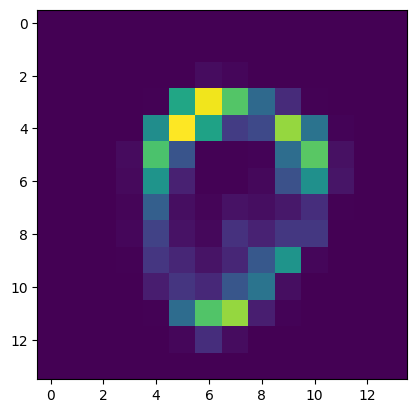

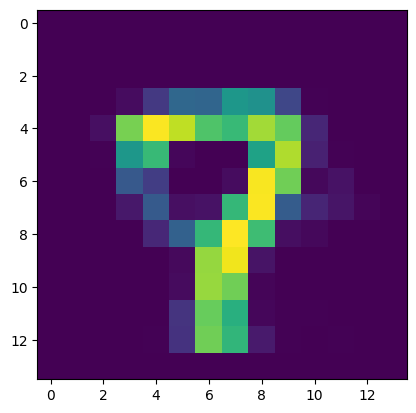

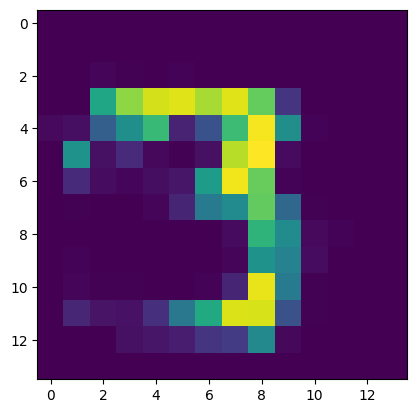

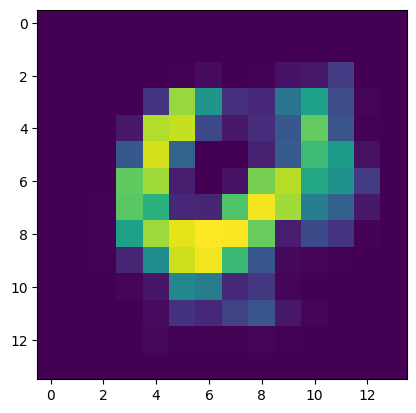

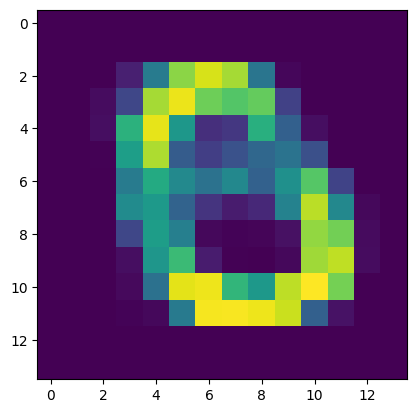

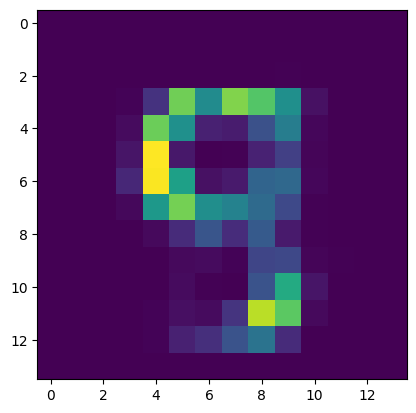

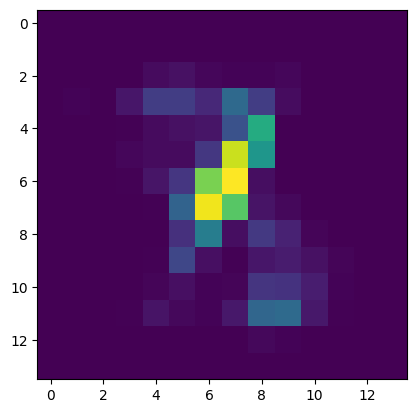

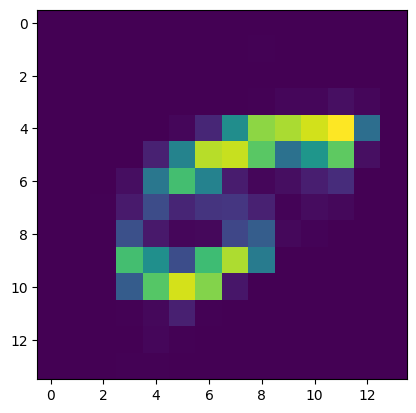

In [29]:

for i in range(8):
  
  x = np.random.normal(0,1, 8)
  x= x.astype(np.float32)
  x=torch.from_numpy(x)
  x= x.to(device)
  recon = model.decoder(x)
  b = recon.reshape((14,14))
  print(x)
  f, axarr = plt.subplots(1) 
  axarr.imshow(b.detach().cpu().numpy())

### (vi)
### Comparing the reconstruction log likelihood term in ELBO on Training vs Validation set

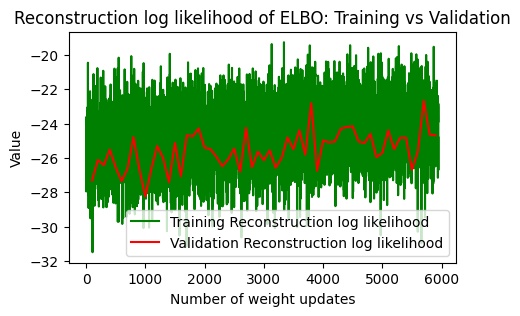

In [30]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'g', label='Training Reconstruction log likelihood')
# Ensure x/y are numpy arrays without grads
import numpy as _np
_update = _np.array(update, dtype=float)
_testl = _np.array(testl, dtype=float)
plt.plot(_update, _testl, 'r', label='Validation Reconstruction log likelihood')
plt.title('Reconstruction log likelihood of ELBO: Training vs Validation')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()
plt.show()